In [2]:
# Import the libraries
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math
import json
from IPython.core.pylabtools import figsize

figsize(15, 7) 

### Utils

In [3]:
def read_data(path,o_dtname="Datetime",c_dtname = 'datetime',names=None,skiprows=None):
    df = pd.read_csv(path, sep=',', 
                     parse_dates={c_dtname:[o_dtname]}, 
                     infer_datetime_format=True, 
                     low_memory=False, 
                     na_values=['nan','?'], 
                     index_col=c_dtname,
                     names=names,
                    skiprows=skiprows)

    #df = df.reindex(index=df.index[:,:-1])
    print(df.isnull().sum())
    # filling nan with mean in any columns
    #for j in range(df.shape[1]):        
        #df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
        
    #df.iloc[:,4:] = df.iloc[:,4:]*100
    #another sanity check to make sure that there are not more any nan
    #print(df.isnull().sum())
    #print(df.head())
    return df
#draw_trend
def draw_trend(df,groups,bound=200):
    #figsize(15,10) 
    
    anomly_df = df.copy()
    anomly_df[anomly_df>0] = np.nan
    
    i=1
    Values = df.values
    Anomaly = anomly_df.values
    cols = groups
    
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        plt.plot(Anomaly[:bound, group],color='red',linewidth=8)
        plt.title(df.columns[group], y=0.80, loc='right')
        #plt.xticks(range(0,4020,20))
        i += 1
    plt.show()
    print('\n')

def draw_trend_resample(df,groups,resample_freq,bound=200):
    #figsize(15,10) 
    i=1
    Values = df.resample(resample_freq).mean().values
    cols = groups
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        #plt.xticks(range(0,bound+10,10))
        plt.title(df.columns[group]+' resample-{}'.format(resample_freq), y=0.80, loc='right')
        i += 1
    plt.tight_layout()
    plt.show()
    
    print('\n')
#draw_corr
def show_corr(df,group):
    plt.matshow(df.iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_original', size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    
def show_corr_resample(df,group,resample_freq):
    plt.matshow(df.resample(resample_freq).mean().iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_resample-{}'.format(resample_freq), size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    

In [4]:
from scipy import stats
def gen_dataset(data,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data.iloc[i-x_window_size:i, :-1].values)
        
        if np.sum(data.iloc[i-x_window_size:i, -1].values) >= 1:
            y_train.append(1)
        else:
            y_train.append(0)

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    
    #X_train = np.reshape(X_train, (X_train.shape[0], x_window_size,data.shape[1] ))

    """if y_window_size == 1:
        y_train = np.reshape(y_train,(y_train.shape[0], y_train.shape[2]))
    else:
        y_train = np.reshape(y_train,(y_train.shape[0],y_window_size,y_train.shape[2]))"""
        
    print("Gen data info:")
    print("X_data_shape:{}".format(X_train.shape))
    print("y_data_shape:{}".format(y_train.shape))
    print("\n")
          
    return X_train,y_train

def data_scaling(data,X_win_size,y_win_size,mode='robust'):
    
    assert mode == 'robust' or mode == 'minmax','Wrong mode name'
    print("Mode:{}\n".format(mode))
    print(data.describe())
    
    #Record training data index
    data_index = data.shape[0]
   
    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler,RobustScaler
    if mode =='robust':
         #RobustScaler
        scaler = RobustScaler()
        data[list(data.columns)[:-1]] = scaler.fit_transform(data[list(data.columns)[:-1]])     
    elif mode == 'minmax':        
        #MinMaxScaler
        scaler = MinMaxScaler()
        data.iloc[:,:-1] = scaler.fit_transform(data.iloc[:,:-1])     
    
    print(data.describe())
    #generate dataset
    data_X,data_y = gen_dataset(data,X_win_size,y_win_size)
    
    return data_X,data_y,scaler,data,scaler.get_params()


CPU utilization (%)                               0
Disk (0 C:) - % Disk saturation                   0
Disk (0 C:) - % Idle Time                         0
Disk (0 C:) - Average Disk Bytes Read             0
Disk (0 C:) - Average Disk Bytes Total            0
Disk (0 C:) - Average Disk Bytes Write            0
Disk (0 C:) - Avg. Disk sec/Read (Latency)        0
Disk (0 C:) - Avg. Disk sec/Transfer (Latency)    0
Disk (0 C:) - Avg. Disk sec/Write (Latency)       0
Disk (1 D:) - % Disk saturation                   0
Disk (1 D:) - % Idle Time                         0
Disk (1 D:) - Average Disk Bytes Read             0
Disk (1 D:) - Average Disk Bytes Total            0
Disk (1 D:) - Average Disk Bytes Write            0
Disk (1 D:) - Avg. Disk sec/Read (Latency)        0
Disk (1 D:) - Avg. Disk sec/Transfer (Latency)    0
Disk (1 D:) - Avg. Disk sec/Write (Latency)       0
Memory used  (%)                                  0
C_anomaly_label                                   0
dtype: int64

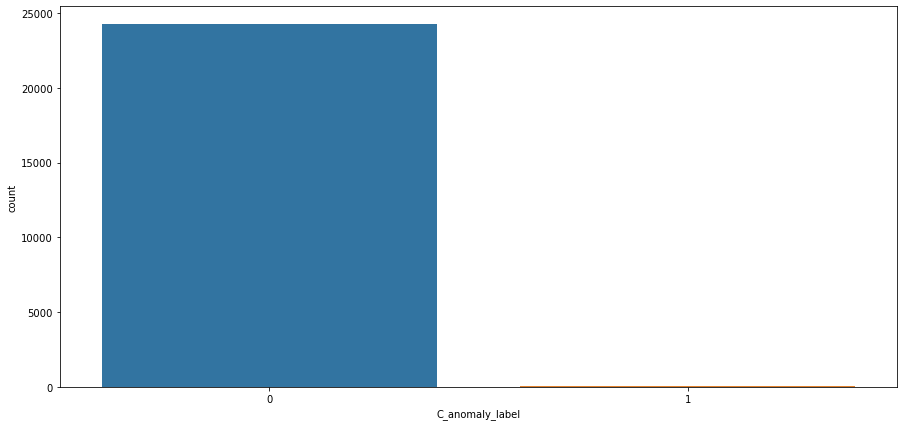

Mode:minmax

       CPU utilization (%)  Disk (0 C:) - % Disk saturation  \
count          9705.000000                      9705.000000   
mean             79.849417                         4.338100   
std               5.637271                        16.071846   
min              58.230900                        -0.419300   
25%              76.414300                         0.006500   
50%              77.208200                         0.258100   
75%              84.028100                         0.791400   
max              98.369300                       100.000000   

       Disk (0 C:) - % Idle Time  Disk (0 C:) - Average Disk Bytes Read  \
count                9705.000000                            9705.000000   
mean                   95.676983                            4804.593842   
std                    16.048433                           16239.712769   
min                     0.000000                               0.000000   
25%                    99.198100            

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Gen data info:
X_data_shape:(9688, 16, 18)
y_data_shape:(9688,)


Mode:minmax

       CPU utilization (%)  Disk (0 C:) - % Disk saturation  \
count          9461.000000                      9461.000000   
mean             79.400732                         1.539756   
std               5.657357                         8.735639   
min              67.725900                        -0.439900   
25%              76.145800                         0.003600   
50%              76.916000                         0.124200   
75%              80.715000                         0.477300   
max              98.262900                        97.637200   

       Disk (0 C:) - % Idle Time  Disk (0 C:) - Average Disk Bytes Read  \
count                9461.000000                            9461.000000   
mean                   98.503732                            3013.138636   
std                     8.561755                           13153.658549   
min                     2.362800                     

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Gen data info:
X_data_shape:(9444, 16, 18)
y_data_shape:(9444,)


Mode:minmax

       CPU utilization (%)  Disk (0 C:) - % Disk saturation  \
count          2039.000000                      2039.000000   
mean              0.543457                         0.030661   
std               0.144227                         0.127280   
min               0.345385                         0.003760   
25%               0.451087                         0.004234   
50%               0.472672                         0.006372   
75%               0.681031                         0.011228   
max               0.963257                         1.000000   

       Disk (0 C:) - % Idle Time  Disk (0 C:) - Average Disk Bytes Read  \
count                2039.000000                            2039.000000   
mean                    0.967549                               0.015773   
std                     0.133937                               0.050824   
min                     0.000000                     

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Gen data info:
X_data_shape:(2022, 16, 18)
y_data_shape:(2022,)


Mode:minmax

       CPU utilization (%)  Disk (0 C:) - % Disk saturation  \
count          1795.000000                      1795.000000   
mean              0.391774                         0.023941   
std               0.183207                         0.116524   
min               0.000000                         0.000000   
25%               0.282857                         0.004514   
50%               0.303628                         0.005423   
75%               0.559597                         0.007772   
max               0.929613                         1.000000   

       Disk (0 C:) - % Idle Time  Disk (0 C:) - Average Disk Bytes Read  \
count                1795.000000                            1795.000000   
mean                    0.979073                               0.011838   
std                     0.106051                               0.055642   
min                     0.000000                     

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Gen data info:
X_data_shape:(1778, 16, 18)
y_data_shape:(1778,)


Mode:minmax

       CPU utilization (%)  Disk (0 C:) - % Disk saturation  \
count          5465.000000                      5465.000000   
mean             75.824077                         3.618859   
std              19.913523                        15.739277   
min               0.105845                        -0.429700   
25%              76.069200                         0.004572   
50%              77.571000                         0.149100   
75%              84.195400                         0.708000   
max              99.579800                       100.000000   

       Disk (0 C:) - % Idle Time  Disk (0 C:) - Average Disk Bytes Read  \
count                5465.000000                            5465.000000   
mean                   90.521092                            3984.647228   
std                    27.435740                           17712.155340   
min                     0.000000                     

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Gen data info:
X_data_shape:(5448, 16, 18)
y_data_shape:(5448,)


(19132, 16, 18)
(3800, 16, 18)
(5448, 16, 18)


In [27]:
from sklearn.model_selection import train_test_split
import seaborn as sns

X_WIN = 16
Y_WIN = 1
SCALE_MODE = 'minmax'

df = read_data("6Vdata_diskio.csv",o_dtname="datetime",c_dtname = 'dt')
sns.countplot(x = 'C_anomaly_label',
              data = df,
              order = df.C_anomaly_label.value_counts().index)
plt.show()
test_df = df.loc["2021-10-25 12":"2021-10-27 00"]
df1 = df.loc[:"2021-10-25 12",:]
df2 = df.loc["2021-10-27 00":,:]
x_val1 = df1.iloc[7666:]
x_val2 = df2.iloc[7666:]

df1_X, df1_y, scaler,df_scale,param = data_scaling(df1,X_WIN,Y_WIN,mode=SCALE_MODE)
df2_X, df2_y, scaler,df_scale,param = data_scaling(df2,X_WIN,Y_WIN,mode=SCALE_MODE)
x_val1_X, x_val1_y, scaler,df_scale,param = data_scaling(x_val1,X_WIN,Y_WIN,mode=SCALE_MODE)
x_val2_X,x_val2_y, scaler,df_scale,param = data_scaling(x_val2,X_WIN,Y_WIN,mode=SCALE_MODE)
X_test,y_test, scaler,df_scale,param = data_scaling(test_df,X_WIN,Y_WIN,mode=SCALE_MODE)


X_train = np.concatenate([df1_X,df2_X],axis=0)
y_train = np.concatenate([df1_y,df2_y],axis=0)
X_val = np.concatenate([x_val1_X,x_val2_X],axis=0)
y_val = np.concatenate([x_val1_y,x_val2_y],axis=0)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

In [29]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)
X_train.shape

(19132, 288)

In [34]:
from __future__ import division
from __future__ import print_function

import os
import sys


from pyod.models.vae import VAE
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print




# train VAE detector (Beta-VAE)
clf_name = 'VAE'
clf = VAE(encoder_neurons=[128,64,32], 
                         decoder_neurons=[32,64,128], 
                         latent_dim=32, 
                         epochs=10, 
                         batch_size=32, 
                         dropout_rate=0.2, 
                         l2_regularizer=0.1, 
                         validation_size=0.1, 
                         preprocessing=False, 
                         verbose=2, 
                         random_state=7, 
                         contamination=0.1, 
                         gamma=1.0, 
                         capacity=0.0)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
#print("\nOn Training Data:")
#evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


   

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 288)]        0           []                               
                                                                                                  
 dense_47 (Dense)               (None, 288)          83232       ['input_5[0][0]']                
                                                                                                  
 dense_48 (Dense)               (None, 128)          36992       ['dense_47[0][0]']               
                                                                                                  
 dropout_34 (Dropout)           (None, 128)          0           ['dense_48[0][0]']               
                                                                                            

In [30]:
from __future__ import division
from __future__ import print_function

import os
import sys


from pyod.models.vae import VAE
from pyod.models.auto_encoder import AutoEncoder

from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print




# train VAE detector (Beta-VAE)
clf_name = 'AutoEncoder'

clf = AutoEncoder( 
                          
                     
                         epochs=100, 
                         batch_size=32, 
                         dropout_rate=0.2, 
                         l2_regularizer=0.1, 
                         validation_size=0.1, 
                         preprocessing=False, 
                         verbose=0, 
                         random_state=7, 
                         contamination=0.1  )
clf.fit(X_train)




   

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[64, 32, 32, 64],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x0000025875007B80>,
      optimizer='adam', output_activation='sigmoid', preprocessing=False,
      random_state=7, validation_size=0.1, verbose=0)

In [12]:
from pyod.models.pca import PCA
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize




# train PCA detector
clf_name = 'PCA'
clf = PCA(n_components=3)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
#evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:

On Test Data:
PCA ROC:0.7444, precision @ rank n:0.2358


In [33]:
from pyod.utils.example import visualize


# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores


visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True, save_figure=True)

ValueError: Input data has to be 2-d for visualization. The input data has (19132, 288).